# Hands-on: High Performance Computing applied to Industry

Welcome to _Hands-on_. In this short course you will learn several techniques for scaling computation on industrial applications, with an emphasis on [OPENMP, OPENACC, CUDA] which allows for elegant parallelization applications codes and has been proven to scale very well on supercomputational systems.

## The Coding Environment

For your work today, you have access to several computational resources in the cloud. Run the following cell to see the features available to you today.

In [ ]:
!nvidia-smi topo -m 

	GPU0	CPU Affinity	NUMA Affinity
GPU0	 X 	0-11		N/A

Legend:

  X    = Self
  SYS  = Connection traversing PCIe as well as the SMP interconnect between NUMA nodes (e.g., QPI/UPI)
  NODE = Connection traversing PCIe as well as the interconnect between PCIe Host Bridges within a NUMA node
  PHB  = Connection traversing PCIe as well as a PCIe Host Bridge (typically the CPU)
  PXB  = Connection traversing multiple PCIe bridges (without traversing the PCIe Host Bridge)
  PIX  = Connection traversing at most a single PCIe bridge
  NV#  = Connection traversing a bonded set of # NVLinks


While your work today will be on a single node, all the techniques you learn today, can be used to run your applications across clusters of multi-GPU nodes.

## Table of Contents

During the workshop today you will work through each of the following notebooks with your instructor:

- [Accelerate a Thermal Conductivity Application](heat/heat.ipynb): You will begin by familiarizing yourself with a single GPU implementation of the Accelerate a Thermal Conductivity Application, which we will use to introduce  multi-resources programming paradigms.
- [Seismic Modelling - 1D Wave Equation](3-SIINTEC2022-wave.ipynb): You apply your day's learnings by refactoring a single GPU 1D wave equation solver to run on supercomputing environment.
- [Final Exercise](4-SIINTEC2022-FinalExercise.ipynb): In this exercise you apply your concepts.

## Matrix Multiple Benchmark

### A Single CPU Implementation 

In [ ]:
%%writefile mm.c

#include <stdio.h>
#include <stdlib.h>

void fill_matrix(double *A, int n){

  int i,j;
 
  for(i = 0; i < n; i++)
    for(j = 0; j < n; j++)
      A[i*n+j] = rand()%(10-1)*1;
  
}

void print_matrix(double *A, int n){

  int i,j;

  for (i=0; i < n; i++){
    for (j=0; j < n; j++)
      printf("%1.2f\t", A[i*n+j]);
    printf("\n");
  }

  printf("\n");

}

int main(int argc, char **argv){

 int n = atoi(argv[1]);  
 int i, j, k;

 double  *A = (double *) malloc (sizeof(double) * n * n);
 double  *B = (double *) malloc (sizeof(double) * n * n);
 double  *C = (double *) malloc (sizeof(double) * n * n);

 fill_matrix(A,n);
 fill_matrix(B,n);

 for (i = 0; i < n; i++) 
  for (j = 0; j < n; j++)
    for (k = 0; k < n; k++) 
      C[i*n+j]+=A[i*n+k]*B[k*n+j];

 print_matrix(A,n);
 print_matrix(B,n);
 print_matrix(C,n);

 return 0;

}

Writing mm.c


In [ ]:
!gcc mm.c -o mm -O3

In [ ]:
!./mm 8

1.00	7.00	0.00	7.00	5.00	7.00	1.00	3.00	
6.00	1.00	5.00	4.00	5.00	7.00	5.00	4.00	
6.00	0.00	7.00	1.00	8.00	8.00	6.00	6.00	
8.00	8.00	8.00	4.00	1.00	1.00	5.00	0.00	
0.00	3.00	5.00	3.00	1.00	7.00	4.00	7.00	
6.00	0.00	0.00	2.00	5.00	4.00	5.00	2.00	
2.00	3.00	2.00	1.00	1.00	8.00	8.00	0.00	
5.00	5.00	4.00	4.00	6.00	0.00	5.00	6.00	

2.00	8.00	7.00	3.00	4.00	2.00	0.00	0.00	
0.00	0.00	2.00	6.00	2.00	5.00	6.00	5.00	
7.00	6.00	6.00	8.00	5.00	3.00	6.00	2.00	
8.00	1.00	6.00	6.00	8.00	0.00	1.00	1.00	
7.00	0.00	3.00	2.00	0.00	1.00	2.00	1.00	
8.00	3.00	5.00	2.00	6.00	0.00	7.00	2.00	
7.00	2.00	8.00	1.00	6.00	5.00	1.00	5.00	
4.00	6.00	0.00	4.00	6.00	2.00	3.00	2.00	

168.00	56.00	121.00	124.00	140.00	53.00	118.00	72.00	
221.00	137.00	188.00	133.00	179.00	70.00	116.00	71.00	
255.00	163.00	202.00	142.00	187.00	83.00	139.00	81.00	
154.00	129.00	192.00	169.00	156.00	106.00	114.00	88.00	
178.00	104.00	124.00	124.00	163.00	65.00	127.00	77.00	
138.00	84.00	129.00	61.00	106.00	46.00	51.00	44.00	
153.00	69.00	14

#### How to measure execution time in C code?

In [ ]:
%%writefile mm-time.c

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>

void fill_matrix(double *A, int n){

  int i,j;
 
  for(i = 0; i < n; i++)
    for(j = 0; j < n; j++)
      A[i*n+j] = rand()%(10-1)*1;
  
}

void print_matrix(double *A, int n){

  int i,j;

  for (i=0; i < n; i++){
    for (j=0; j < n; j++)
      printf("%1.2f\t", A[i*n+j]);
    printf("\n");
  }

  printf("\n");

}

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);  
  int i, j, k;

  double  *A = (double *) malloc (sizeof(double) * n * n);
  double  *B = (double *) malloc (sizeof(double) * n * n);
  double  *C = (double *) malloc (sizeof(double) * n * n);

  fill_matrix(A,n);
  fill_matrix(B,n);

  // Start measuring time
  struct timeval begin, end;
  gettimeofday(&begin, 0);
    
  for (i = 0; i < n; i++) 
   for (j = 0; j < n; j++)
     for (k = 0; k < n; k++) 
       C[i*n+j]+=A[i*n+k]*B[k*n+j];
    
  gettimeofday(&end, 0);
  long seconds = end.tv_sec - begin.tv_sec;
  long microseconds = end.tv_usec - begin.tv_usec;
  double elapsed = seconds + microseconds*1e-6;
    
   printf("%d x %d  %.3f seconds\n", n, n, elapsed);  

  //print_matrix(A,n);
  //print_matrix(B,n);
  //print_matrix(C,n);

  return 0;
}

Writing mm-time.c


In [ ]:
!gcc mm-time.c -o mm-time -O3

In [ ]:
!./mm-time 1000

1000 x 1000  2.709 seconds


#### How to profilling this code?

In [ ]:
!gcc mm-time.c -o mm-profilling -pg

In [ ]:
!./mm-profilling 1000

1000 x 1000  8.204 seconds


In [ ]:
!gprof -b mm-profilling gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
100.28      8.21     8.21                             main
  0.00      8.21     0.00        2     0.00     0.00  fill_matrix

			Call graph


granularity: each sample hit covers 2 byte(s) for 0.12% of 8.21 seconds

index % time    self  children    called     name
                                                 <spontaneous>
[1]    100.0    8.21    0.00                 main [1]
                0.00    0.00       2/2           fill_matrix [2]
-----------------------------------------------
                0.00    0.00       2/2           main [1]
[2]      0.0    0.00    0.00       2         fill_matrix [2]
-----------------------------------------------

Index by function name

   [2] fill_matrix             [1] main


### MPI

#### Installation

In [ ]:
!sudo apt-get install libopenmpi-dev

In [ ]:
%%writefile mm-mpi.c

#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <sys/time.h>

double *A, *B, *C;

void fill_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++)
    for(int j = 0; j < n; j++)
       A[i * n + j] = rand()%(10-1)*1;;
}

void print_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++) {
    for(int j = 0; j < n; j++)
       printf("%1.2f\t", A[i * n + j]); 
    printf("\n");  
  }
 
  printf("\n");

}

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);
  int myrank, np, from, to;
  int tag = 1000;
  
  A = (double *) malloc (sizeof(double) * n * n);
  B = (double *) malloc (sizeof(double) * n * n);
  C = (double *) malloc (sizeof(double) * n * n);

  // Start measuring time
  struct timeval begin, end;
  gettimeofday(&begin, 0);
  
  MPI_Init (&argc, &argv);
  MPI_Comm_rank(MPI_COMM_WORLD, &myrank);
  MPI_Comm_size(MPI_COMM_WORLD, &np); 
  MPI_Status status;
    
  from = (myrank * n) / np;
  to   = ((myrank + 1) * n) / np;

  if (myrank == 0) {
    fill_matrix(A, n);
    fill_matrix(B, n);
  }

  MPI_Bcast(B,  n * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);
  MPI_Scatter(A, n * n / np, MPI_DOUBLE, A + (from * n), n * n / np, MPI_DOUBLE, 0, MPI_COMM_WORLD);
  
  for(int i = from; i < to; i++) 
    for(int j = 0; j < n; j++) 
        for(int k = 0; k < n; k++)
            C[i * n + j] += A[i * n + k] * B[k * n + j];
    
  MPI_Gather (C + (from * n), (n * n) / np, MPI_DOUBLE, C, (n * n) / np, MPI_DOUBLE, 0, MPI_COMM_WORLD);
  
  //if (myrank == 0) {
    //print_matrix(A, n);
    //print_matrix(B, n);
    //print_matrix(C, n);
  //}

  gettimeofday(&end, 0);
  long seconds = end.tv_sec - begin.tv_sec;
  long microseconds = end.tv_usec - begin.tv_usec;
  double elapsed = seconds + microseconds*1e-6;
    
  if (myrank == 0) 
    printf("%d x %d  %.3f seconds\n", n, n, elapsed);  

  MPI_Finalize();

  return 0;
}

Writing mm-mpi.c


In [ ]:
!mpicc mm-mpi.c -o mm-mpi

In [ ]:
!mpirun --allow-run-as-root -np 10 ./mm-mpi 1000

1000 x 1000  2.340 seconds


### OpenMP

#### Instalation 

In [ ]:
!sudo apt-get install libomp-dev

In [ ]:
%%writefile mm-omp.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <sys/time.h>

void fill_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++)
    for(int j = 0; j < n; j++)
      A[i*n+j] = rand()%(10-1)*1;
}

void print_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++){
    for(int j = 0; j < n; j++)
      printf("%1.2f\t", A[i*n+j]);
   printf("\n");
  }

  printf("\n");
}

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);  
  int i, j, k;

  double  *A = (double *) malloc(sizeof(double) * n * n);
  double  *B = (double *) malloc(sizeof(double) * n * n);
  double  *C = (double *) malloc(sizeof(double) * n * n);

  fill_matrix(A,n);
  fill_matrix(B,n);

  //Measuring time
  struct timeval begin, end;
  gettimeofday(&begin, 0);
     
  #pragma omp parallel for private(i,j,k)
   for(i = 0; i < n; i++) 
    for(j = 0; j < n; j++)
      for(k = 0; k < n; k++) 
        C[i*n+j] += A[i*n+k] * B[k*n+j];
    
   gettimeofday(&end, 0);
   long seconds = end.tv_sec - begin.tv_sec;
   long microseconds = end.tv_usec - begin.tv_usec;
   double elapsed = seconds + microseconds*1e-6;
    
   printf("%d x %d  %.3f seconds\n", n, n, elapsed);    
    
   //print_matrix(A,n);
   //print_matrix(B,n);
   //print_matrix(C,n);

   return 0;
}


Writing mm-omp.c


In [ ]:
!gcc mm-omp.c -o mm-omp -fopenmp -O3

In [ ]:
!OMP_NUM_THREADS=6 ./mm-omp 1000

1000 x 1000  0.446 seconds


### CUDA

In [ ]:
%%writefile mm-CUDA.cu

#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <sys/time.h>

__global__ void kernel(double *A, double *B, double *C, int n) 
{  
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  int j = blockIdx.y * blockDim.y + threadIdx.y;

  if(i < n && j < n)
    for( int k = 0; k < n; k++) 
       C[i*n+j] += A[i*n+k] * B[k*n+j];

}
 
void mult_matrix_cpu(double *A, double *B, double *C, int n) 
{
   for(int i = 0; i < n; i++) 
      for(int j = 0; j < n; j++)
         for(int k = 0; k < n; k++) 
            C[i*n+j]+=A[i*n+k]*B[k*n+j];
        
}

void fill_matrix(double *A, int n)
{ 
   for(int i=0; i < n; i++)
     for(int j=0; j < n; j++)
       A[i*n+j] = rand()%(10-1)*1;
   
}

void print_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++){
    for(int j = 0; j < n; j++)
      printf("%1.2f\t", A[i*n+j]);
    printf("\n");
  }

  printf("\n");

}

int main(int argc, char **argv)
{
    int n = atoi(argv[1]);
    int sizeblock = atoi(argv[2]);

    /*Host*/
    double *A_host=(double *) malloc (n * n * sizeof(double));
    double *B_host=(double *) malloc (n * n * sizeof(double));
    double *C_host=(double *) malloc (n * n * sizeof(double));
        
    fill_matrix(A_host,n);
    fill_matrix(B_host,n);
      
    //print_matrix(A_host,n);
    //print_matrix(B_host,n);

    //Measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);
    
    /*Device*/
    double *A_device;
    double *B_device;
    double *C_device;

    cudaMalloc((void**)&A_device, n * n * sizeof(double) ); 
    cudaMalloc((void**)&B_device, n * n * sizeof(double) ); 
    cudaMalloc((void**)&C_device, n * n * sizeof(double) ); 

    cudaMemcpy(A_device, A_host, n * n * sizeof(double), cudaMemcpyHostToDevice ); 
    cudaMemcpy(B_device, B_host, n * n * sizeof(double), cudaMemcpyHostToDevice ); 

    /*Computational GRID: (Grid: 2D Block: 2D)*/
    dim3 NUMBER_OF_BLOCKS ( (int) ceil( (float) n / sizeblock), (int) ceil( (float)n / sizeblock) );
    dim3 NUMBER_OF_THREADS( sizeblock, sizeblock);  

          kernel<<< NUMBER_OF_BLOCKS, NUMBER_OF_THREADS >>>(A_device, B_device, C_device, n);      
          cudaDeviceSynchronize();

    cudaMemcpy(C_host, C_device, n * n * sizeof(double), cudaMemcpyDeviceToHost ); 

    //print_matrix(C_host, n );

    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;
    
    printf("%d x %d  %.3f seconds\n", n, n, elapsed);  
    
    cudaFree(A_device );
    cudaFree(B_device );
    cudaFree(C_device );
  
    return 0;
}

Writing mm-CUDA.cu


In [ ]:
!nvcc mm-CUDA.cu -o mm-CUDA

In [ ]:
!./mm-CUDA 1000 32

1000 x 1000  0.361 seconds


### OpenACC

In [ ]:
%%writefile mm-openacc.c

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>

void fill_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++)
    for(int j = 0; j < n; j++)
      A[i*n+j] = rand()%(10-1)*1; 
}

void print_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++){
    for(int j = 0; j < n; j++)
      printf("%1.2f\t", A[i*n+j]);
    printf("\n");
  }

  printf("\n");

}

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);  
  int i, j, k;

  double *A = (double *) malloc (sizeof(double) * n * n);
  double *B = (double *) malloc (sizeof(double) * n * n);
  double *C = (double *) malloc (sizeof(double) * n * n);

  fill_matrix(A,n);
  fill_matrix(B,n);
 
  //Measuring time
  struct timeval begin, end;
  gettimeofday(&begin, 0);
      
  #pragma acc data present_or_copyin(A[:n*n], B[:n*n], n) copyout(C[:n*n])
   #pragma acc parallel 
    #pragma acc loop
     for(i = 0; i < n; i++) 
       for(j = 0; j < n; j++)
         for(k = 0; k < n; k++) 
           C[i*n+j] += A[i*n+k] * B[k*n+j];

   gettimeofday(&end, 0); 
   long seconds = end.tv_sec - begin.tv_sec;
   long microseconds = end.tv_usec - begin.tv_usec;
   double elapsed = seconds + microseconds*1e-6;
    
    printf("%d x %d  %.3f seconds\n", n, n, elapsed);  
     
  //print_matrix(A,n);
  //print_matrix(B,n);
  //print_matrix(C,n);

  return 0;
}

Writing mm-openacc.c


In [ ]:
!pgcc mm-openacc.c -o mm-openacc -acc


Please obtain a new version at http://www.pgroup.com/community or
contact PGI Sales at sales@pgroup.com to obtain a perpetual license.



In [ ]:
!./mm-openacc 1000

1000 x 1000  0.590 seconds


### OpenMP5

In [ ]:
%%writefile mm-omp5.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <sys/time.h>

void fill_matrix(double *A, int n)
{ 
  for(int i = 0; i < n; i++)
    for(int j = 0; j < n; j++)
      A[i*n+j] = rand()%(10-1)*1; 
}

void print_matrix(double *A, int n)
{
  for(int i = 0; i < n; i++){
    for(int j = 0; j < n; j++)
      printf("%1.2f\t", A[i*n+j]);
    printf("\n");
  }
  
  printf("\n");
}

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);  
  int i, j, k;

  double  *A = (double *) malloc (sizeof(double) * n * n);
  double  *B = (double *) malloc (sizeof(double) * n * n);
  double  *C = (double *) malloc (sizeof(double) * n * n);

  fill_matrix(A,n);
  fill_matrix(B,n);

  //Measuring time
  struct timeval begin, end;
  gettimeofday(&begin, 0);
    
  #pragma omp target data map(to:A[:n*n], B[:n*n], n) map(from:C[:n*n])
  {
   #pragma omp target teams distribute parallel for private(i,j,k)
   for(i = 0; i < n; i++) 
     for(j = 0; j < n; j++)
       for(k = 0; k < n; k++) 
         C[i*n+j] += A[i*n+k] * B[k*n+j];
  }

   gettimeofday(&end, 0); 
   long seconds = end.tv_sec - begin.tv_sec;
   long microseconds = end.tv_usec - begin.tv_usec;
   double elapsed = seconds + microseconds*1e-6;
    
    printf("%d x %d  %.3f seconds\n", n, n, elapsed);   
  
  //print_matrix(A,n);
  //print_matrix(B,n);
  //print_matrix(C,n);

  return 0;
}

Writing mm-omp5.c


In [ ]:
!clang mm-omp5.c -o mm-omp5 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda

In [ ]:
!./mm-omp5 1000

1000 x 1000  2.252 seconds


| Program Version      | Execution Time (sec.)  | Speedup      |
| :---                 |    :----:              |        ---:  |
| Serial               | 1.44                   | 1X           |
| OpenMP T=6           | 0.28                   | 5.14X        |
| OpenACC              | 0.59                   | 2.44X        | 
| CUDA                 | 0.17                   | 8.47X        | 
| OpenMP5              | 2.25                   | 0.64X        | 

## Numeric Integration Benchmark

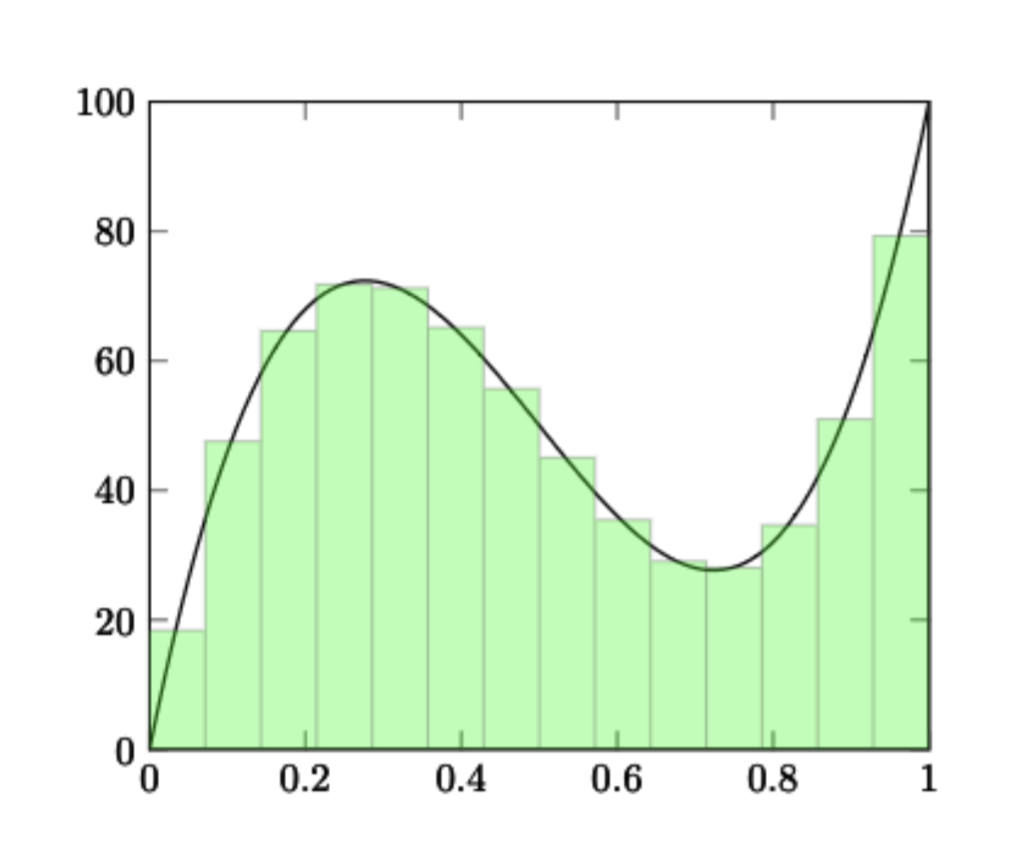

### Sequential Code

In [ ]:
%%writefile integral.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

/* f(x) function from which the integral will be calculated. */
double f(double x)
{
 return 100 * x + sin(2 * x * M_PI);
}

/* Calculates the integral of the function betweens point a and b. */
double integral(double a, double b, int n)
{
   double h, s = 0, result;
   int i;

   h = (b - a) / n;

   for (i = 0; i < n; i++)
   {
     s += f(a + h * (i + 0.5));
   }

   result = h * s;

   return result;
}


int main(int argc, char *argv[])
{
   int steps = atoi(argv[1]);

   double start = omp_get_wtime();
      double result = integral(0, 1, steps);
   double end = omp_get_wtime();

   printf("%f\t%f\n", end - start, result);

   return 0;
}

Writing integral.c


In [ ]:
!gcc integral.c -o integral -fopenmp -lm

In [ ]:
!./integral 100000000

3.655262	50.000000


### OpenMP

In [ ]:
%%writefile integral-omp.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

/* f(x) function from which the integral will be calculated. */
double f(double x)
{
   return 100 * x + sin(2 * x * M_PI);
}

/* Calculates the integral of the function betweens point a and b. */
double integral(double a, double b, int n)
{
   double h, s = 0, result;
   int i;

   h = (b - a) / n;

   #pragma omp parallel for reduction(+:s)
   for (i = 0; i < n; i++)
   {
      s += f(a + h * (i + 0.5));
   }

   result = h * s;

   return result;
}


int main(int argc, char *argv[])
{
  int steps = atoi(argv[1]);

  double start = omp_get_wtime();
     double result = integral(0, 1, steps);
  double end = omp_get_wtime();

  printf("%f\t%f\n", end - start, result);

  return 0;
}


Overwriting integral-omp.c


In [ ]:
!gcc integral-omp.c -o integral-omp -fopenmp -lm -O3

In [ ]:
!OMP_NUM_THREADS=64 ./integral-omp 100000000

0.110057	50.000000


### MPI

In [ ]:
%%writefile integral-mpi.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <mpi.h>
#include <omp.h>

/* f(x) function from which the integral will be calculated. */
double f(double x)
{
 return 100 * x + sin(2 * x * M_PI);
}

/* Calculates the integral of the function betweens point a and b. */
double integral(double a, double b, int n)
{
   double h, s = 0, result;
   int i;

   h = (b - a) / n;

   for (i = 0; i < n; i++)
   {
     s += f(a + h * (i + 0.5));
   }

   result = h * s;
   
   return result;
}


int main(int argc, char *argv[])
{
   double result = 0, partial_result = 0;
   int steps = atoi(argv[1]);
   int rank, size;

   MPI_Init(&argc, &argv);
   MPI_Comm_rank(MPI_COMM_WORLD, &rank);
   MPI_Comm_size(MPI_COMM_WORLD, &size);
   MPI_Status status;
  
   double start = omp_get_wtime();
      partial_result = integral(rank/size, (rank + 1)/size, steps);
      MPI_Reduce(&partial_result, &result, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
   double end = omp_get_wtime();

   if(rank == 0){ 
      printf("%f\t%f\n",  end - start, result);
   }

   MPI_Finalize();

   return 0;
}


Writing integral-mpi.c


In [ ]:
!mpicc integral-mpi.c -o integral-mpi -fopenmp -lm -O3

In [ ]:
!mpirun --allow-run-as-root -np 16 ./integral-mpi 100000000

2.160934	50.000000


### MPI + OpenMP

In [ ]:
%%writefile integral-mpi+omp.c

#include <mpi.h>
#include <omp.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>


/* f(x) function from which the integral will be calculated. */
double f(double x)
{
 return 100 * x + sin(2 * x * M_PI);
}

/* Calculates the integral of the function betweens point a and b. */
double integral(double a, double b, int n)
{
   double h, s = 0, result;
   int i;

   h = (b - a) / n;

   #pragma omp parallel for reduction(+:s)
   for (i = 0; i < n; i++)
   {
     s += f(a + h * (i + 0.5));
   }

   result = h * s;
   return result;
}


int main(int argc, char *argv[])
{
   double result = 0, partial_result = 0;
   int steps = atoi(argv[1]);
   int rank, size;

   MPI_Init(&argc, &argv);
   MPI_Comm_rank(MPI_COMM_WORLD, &rank);
   MPI_Comm_size(MPI_COMM_WORLD, &size);
   MPI_Status status;
  
   double start = omp_get_wtime();
      partial_result = integral(rank/size, (rank + 1)/size, steps);
      MPI_Reduce(&partial_result, &result, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
   double end = omp_get_wtime();

   if (rank == 0) 
      printf("%f\t%f\n", end - start, result);

   MPI_Finalize();

   return 0;
}


Writing integral-mpi+omp.c


In [ ]:
!mpicc integral-mpi+omp.c -o integral-mpi+omp -fopenmp -lm

In [ ]:
!OMP_NUM_THREADS=8 mpirun --allow-run-as-root -np 16 ./integral-mpi+omp 100000000

1.182848	50.000000


### CUDA

In [1]:
%%writefile integral-1gpu.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <omp.h>

__device__ double f(double x)
{
 return 100 * x + sin(2 * x * M_PI);
}

__global__ void integral(double a, double b, int n, double *result, double *global_result)
{
   double h, s = 0;
   int i = threadIdx.x;

   h = (b - a) / n;

   if(i < n){
       s += f(a + h * (i + 0.5));
   }

   result[i] = h * s;
   //printf("Resultado para a thread %d: %f\n", i, result[i]);

   int k = threadIdx.x;
   double soma = 0;

   if(k == 1){
      for(int j = 0; j < blockDim.x; j++)
         soma += result[j];
      
      *global_result = soma;
   }

}




int main(int argc, char *argv[])
{
   int steps = atoi(argv[1]);

   double a = 0, b = 1;
   double *result, *global_result;

   cudaMallocManaged(&result, steps);
   cudaMallocManaged(&global_result, 1);
   
   dim3 NUMBER_OF_BLOCKS(1);
   dim3 NUMBER_OF_THREADS(steps);
         
   float start = omp_get_wtime();
         
         integral<<<NUMBER_OF_BLOCKS, NUMBER_OF_THREADS>>>(a, b, steps, result, global_result);
         cudaDeviceSynchronize();

   float end = omp_get_wtime();

   printf("%f\t%f\n", end - start, *global_result);
  
   cudaFree(result);
   cudaFree(global_result);

   return 0;
}


Writing integral-1gpu.cu


In [2]:
!nvcc integral-1gpu.cu -o integral-1gpu -Xcompiler -fopenmp -lm

In [ ]:
!./integral-1gpu 100

| Program Version      | Execution Time (sec.)  | Speedup      |
| :---                 |    :----:          |        ---:  |
| Serial               |                    |            |
| OpenMP (T=X threads)   |                    |        |
| MPI (P=Y processes)    |                    |        | 
| Hybrid (T=X, P=Y)       |                    |        | 
| CUDA                 |                    |        | 

## Next

Please continue to the next notebook: Please continue to the next notebook: [Accelerate a Thermal Conductivity Application](2-SIINTEC2022-heat.ipynb).